In [1]:
import numpy as np
import torch
import torch.nn as nn

import torch.nn.functional as F
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score, precision_score, recall_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GATConv

from torch_geometric.datasets import EllipticBitcoinDataset
import pickle

In [2]:
# Set training arguments, set prebuild=True to use builtin PyG models otherwise False
args={
    "epochs":50,
    'lr':0.01,
    'weight_decay':1e-5,
    'prebuild':True,
    'heads':2,
    'hidden_dim': 128, 
    'dropout': 0.5
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

class GAT(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GAT, self).__init__()
        #use our gat message passing 
        self.conv1 = GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = GATConv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x, edge_index, adj=None):
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)
       

In [4]:
class MetricManager(object):
  def __init__(self, modes=["train", "test"]):

    self.output = {}

    for mode in modes:
      self.output[mode] = {}
      self.output[mode]["accuracy"] = []
      self.output[mode]["f1micro"] = []
      self.output[mode]["f1macro"] = []
      self.output[mode]["aucroc"] = []
      #new
      self.output[mode]["precision"] = []
      self.output[mode]["recall"] = []
      self.output[mode]["cm"] = []

  def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):

    # calculate metrics
    pred_labels = pred_scores > threshold
    accuracy = accuracy_score(target_labels, pred_labels)
    f1micro = f1_score(target_labels, pred_labels,average='micro')
    f1macro = f1_score(target_labels, pred_labels,average='macro')
    aucroc = roc_auc_score(target_labels, pred_scores)
    #new
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    cm = confusion_matrix(target_labels, pred_labels)

    # Collect results
    self.output[mode]["accuracy"].append(accuracy)
    self.output[mode]["f1micro"].append(f1micro)
    self.output[mode]["f1macro"].append(f1macro)
    self.output[mode]["aucroc"].append(aucroc)
    #new
    self.output[mode]["recall"].append(recall)
    self.output[mode]["precision"].append(precision)
    self.output[mode]["cm"].append(cm)
    
    return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
  
  # Get best results
  def get_best(self, metric, mode="test"):

    # Get best results index
    best_results = {}
    i = np.array(self.output[mode][metric]).argmax()

    # Output
    for m in self.output[mode].keys():
      best_results[m] = self.output[mode][m][i]
    
    return best_results

In [5]:
class GnnTrainer(object):
  
    def __init__(self, model):
        self.model = model
        self.metric_manager = MetricManager(modes=["train", "test"])

    def train(self, data_train, optimizer, criterion, scheduler, args):

        self.data_train = data_train
        for epoch in range(args['epochs']):
            self.model.train()
            optimizer.zero_grad()
            out = self.model(data_train.x, data_train.edge_index)

            out = out.reshape((data_train.x.shape[0]))
            loss = criterion(out[data_train.train_mask], data_train.y[data_train.train_mask].float())
            ## Metric calculations
            # train data
            target_labels = data_train.y.detach().cpu().numpy()[data_train.train_mask]
            pred_scores = out.detach().cpu().numpy()[data_train.train_mask]
            train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, target_labels)


            ## Training Step
            loss.backward()
            optimizer.step()

            # validation data
            self.model.eval()
            target_labels = data_train.y.detach().cpu().numpy()[data_train.test_mask]
            pred_scores = out.detach().cpu().numpy()[data_train.test_mask]
            test_acc, test_f1,test_f1macro, test_aucroc, test_recall, test_precision, test_cm = self.metric_manager.store_metrics("test", pred_scores, target_labels)

            if epoch%5 == 0:
                print(
                    "epoch: {} - loss: {:.4f} - accuracy train: {:.4f} - train roc: {:.4f}  - train f1micro: {:.4f}".format(epoch, loss.item(), train_acc, train_aucroc, train_f1)
                    + "accuracy test: {:.4f} - test roc: {:.4f}  - test f1micro: {:.4f}".format(test_acc, test_aucroc, test_f1)
                )

    # To predict labels
    def predict(self, data=None, unclassified_only=True, threshold=0.5):
        # evaluate model:
        self.model.eval()
        if data is not None:
            self.data_train = data

        out = self.model(self.data_train)
        out = out.reshape((self.data_train.x.shape[0]))

        if unclassified_only:
            pred_scores = out.detach().cpu().numpy()[self.data_train.test_idx]
        else:
            pred_scores = out.detach().cpu().numpy()

        pred_labels = pred_scores > threshold

        return {"pred_scores":pred_scores, "pred_labels":pred_labels}

    # To save metrics
    def save_metrics(self, save_name, path="./save/"):
        file_to_store = open(path + save_name, "wb")
        pickle.dump(self.metric_manager, file_to_store)
        file_to_store.close()

    # To save model
    def save_model(self, save_name, path="./save/"):
        torch.save(self.model.state_dict(), path + save_name)

In [6]:
data_train = EllipticBitcoinDataset(root="./data").data

In [7]:
num_node_features = data_train['x'].shape[1]
model = GAT(num_node_features, args['hidden_dim'], 1, args)

In [8]:
model.to(device)

GAT(
  (conv1): GATConv(165, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (post_mp): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [11]:
# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gat = GnnTrainer(model)
gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gat.save_metrics("GATprebuilt.results", path="./logs/")
gnn_trainer_gat.save_model("GATprebuilt.pt", path="./logs/")

epoch: 0 - loss: 0.6699 - accuracy train: 0.6232 - train roc: 0.5892  - train f1micro: 0.6232accuracy test: 0.6097 - test roc: 0.5598  - test f1micro: 0.6097
epoch: 5 - loss: 0.2635 - accuracy train: 0.8844 - train roc: 0.9196  - train f1micro: 0.8844accuracy test: 0.9350 - test roc: 0.8049  - test f1micro: 0.9350
epoch: 10 - loss: 0.2240 - accuracy train: 0.8843 - train roc: 0.9289  - train f1micro: 0.8843accuracy test: 0.9349 - test roc: 0.8240  - test f1micro: 0.9349
epoch: 15 - loss: 0.1907 - accuracy train: 0.8946 - train roc: 0.9547  - train f1micro: 0.8946accuracy test: 0.9373 - test roc: 0.8483  - test f1micro: 0.9373
epoch: 20 - loss: 0.1715 - accuracy train: 0.9166 - train roc: 0.9670  - train f1micro: 0.9166accuracy test: 0.9356 - test roc: 0.8492  - test f1micro: 0.9356
epoch: 25 - loss: 0.1575 - accuracy train: 0.9500 - train roc: 0.9728  - train f1micro: 0.9500accuracy test: 0.9351 - test roc: 0.8566  - test f1micro: 0.9351
epoch: 30 - loss: 0.1433 - accuracy train: 0.956

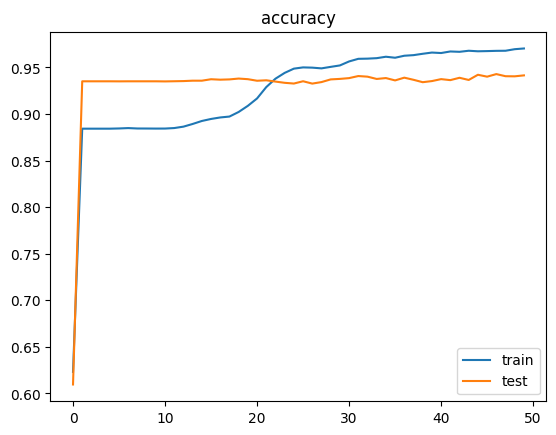

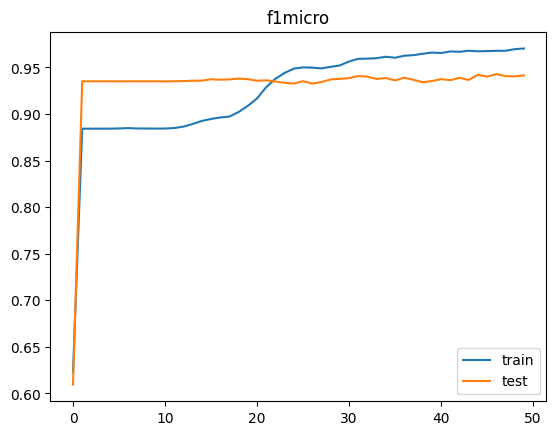

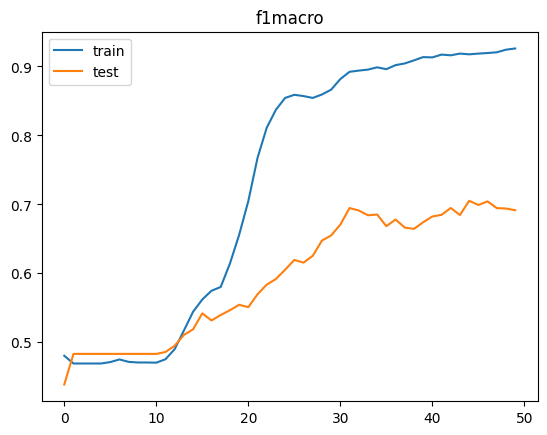

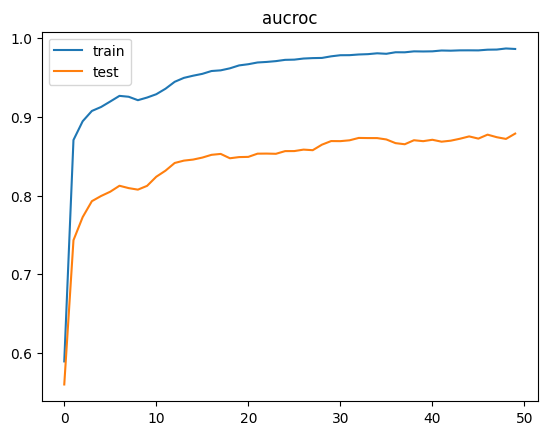

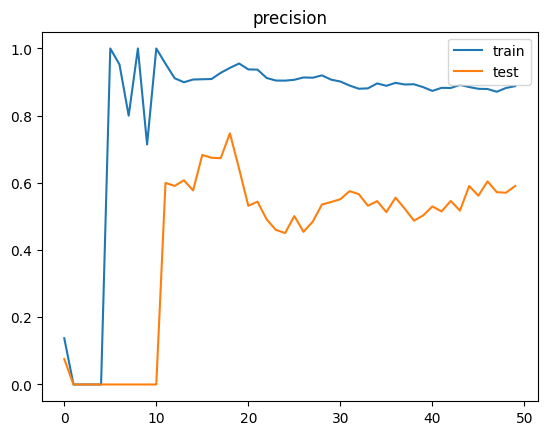

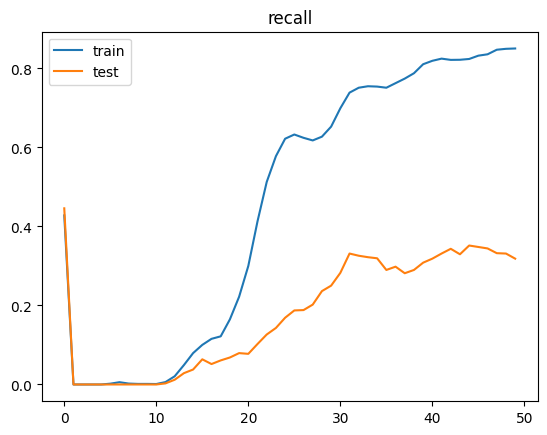

In [13]:
import matplotlib.pyplot as plt

metrics = gnn_trainer_gat.metric_manager.output['train']
test_metrics = gnn_trainer_gat.metric_manager.output['test']

for key in metrics.keys():
    if key == 'cm':
        continue
    
    plt.figure()
    plt.plot(metrics[key])
    plt.plot(test_metrics[key])
    plt.title(key)
    plt.legend(['train', 'test'])


In [9]:
with open("./logs/GATprebuilt.pt", 'rb') as f:
    state_dict = torch.load(f)

In [10]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='node',
        return_type='probs',  # Model returns log probabilities.
    ),
)

In [74]:
from torch_geometric.loader import NeighborLoader

loader = NeighborLoader(
    data=data_train,
    num_neighbors=[10, 10],
    input_nodes=data_train.test_mask,
)

In [75]:
loader_iter = iter(loader) 

In [78]:
for batch in loader_iter:
    if batch['x'].shape[0] > 10 and (batch['y'] == 1).any() > 0:
        break
print(batch)
print(batch.y)

Data(x=[18, 165], edge_index=[2, 17], y=[18], train_mask=[18], test_mask=[18], n_id=[18], e_id=[17], input_id=[1], batch_size=1)
tensor([0, 1, 1, 2, 2, 2, 1, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1])


In [79]:
explanation = explainer(batch.x, batch.edge_index, index=0)
print(explanation.edge_mask)
print(explanation.node_mask)
print(explanation.target)

tensor([0.8532, 0.7414, 0.8390, 0.8433, 0.8663, 0.8757, 0.8181, 0.7979, 0.8090,
        0.8250, 0.0703, 0.9257, 0.9055, 0.9131, 0.9202, 0.9033, 0.9322])
tensor([[0.1399, 0.5665, 0.3104,  ..., 0.3272, 0.3137, 0.1888],
        [0.2704, 0.2194, 0.2816,  ..., 0.7198, 0.2167, 0.1290],
        [0.2687, 0.2217, 0.2797,  ..., 0.6831, 0.2325, 0.1925],
        ...,
        [0.2755, 0.1523, 0.3450,  ..., 0.2493, 0.2048, 0.1807],
        [0.1256, 0.1702, 0.2030,  ..., 0.1441, 0.1666, 0.1639],
        [0.2357, 0.1398, 0.2644,  ..., 0.2820, 0.2733, 0.2745]])
tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1])


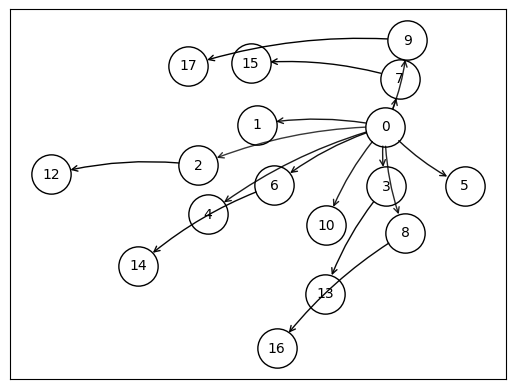

In [80]:
explanation.visualize_graph()

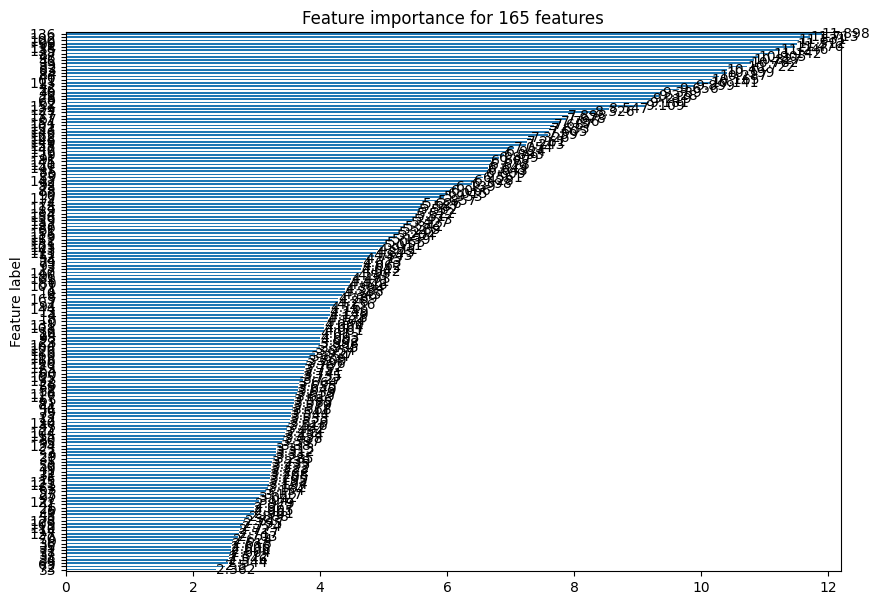

In [81]:
explanation.visualize_feature_importance()

In [82]:
from torch_geometric.utils import to_networkx

In [83]:
explanation['y'] = batch['y']
g = to_networkx(explanation, graph_attrs=['node_mask', 'edge_mask', 'target', 'y'], node_attrs=['x'])

In [84]:
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl


class MplColorHelper:

    def __init__(self, cmap_name, start_val, stop_val):
        self.cmap_name = cmap_name
        self.cmap = plt.get_cmap(cmap_name)
        self.norm = mpl.colors.Normalize(vmin=start_val, vmax=stop_val)
        self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

    def get_rgba(self, val):
        return self.scalarMap.to_rgba(val, bytes=True)

    def get_rgb_str(self, val):
        r, g, b, a = self.get_rgba(val)
        return f"rgb({r},{g},{b})"

In [85]:
import numpy as np
import networkx as nx

def set_node_level_attribution(g):
    '''Get node level attribution'''
    node_level_attribution = np.array(g.graph['node_mask']).sum(axis=1)
    node_level_attribution_dict = { i : node_level_attribution[i] for i in g.nodes }
    nx.set_node_attributes(g, node_level_attribution_dict, name="attribution")

def set_edge_level_attribution(g):
    '''Get edge level attribution'''
    edge_level_attribution = g.graph['edge_mask']
    edge_level_attribution_dict = { edge : edge_level_attribution[i] for i, edge in enumerate(g.edges) }
    nx.set_edge_attributes(g, edge_level_attribution_dict, name="attribution")

def set_node_shapes(g, pos_label_shape='rectangle', neg_label_shape='dot'):
    target = g.graph['target']
    for i, node in enumerate(g.nodes()):
        g.nodes[node]['shape'] = pos_label_shape if target[i] else neg_label_shape

def set_node_colors(g, cmap='winter'):
    '''Set colours based on attribution values'''

    # initialise colour helper
    vals = nx.get_node_attributes(g, 'attribution').values()
    min_val, max_val = min(vals), max(vals)
    node_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each node
    node_colors = { 
        node : node_color_generator.get_rgb_str(data['attribution']) for node, data in g.nodes(data=True) 
    }
    nx.set_node_attributes(g, node_colors, name='color')

def set_edge_colors(g, cmap='winter'):
    vals = nx.get_edge_attributes(g, 'attribution').values()
    min_val, max_val = min(vals), max(vals)
    edge_color_generator = MplColorHelper(cmap, min_val, max_val)

    # get rgb string for each edge
    edge_colors = {
        (u, v) : edge_color_generator.get_rgb_str(data['attribution']) for u, v, data in g.edges(data=True)
    }
    nx.set_edge_attributes(g, edge_colors, name='color')

def set_initial_multipartite_layout(g, scaling_factor=10):
    for layer, nodes in enumerate(nx.topological_generations(g)):
        for node in nodes:
            g.nodes[node]["layer"] = layer

    pos:dict[int, np.array] = nx.multipartite_layout(g, subset_key='layer')

    for node, coord in pos.items():
        g.nodes[node]['x'] = coord[0] * scaling_factor
        g.nodes[node]['y'] = coord[1] * scaling_factor

def rename_node_attribute(g, from_name:str, to_name:str):
    for _, data in g.nodes(data=True):
        try:
            data[to_name] = data.pop(from_name)
        except KeyError: 
            warnings.warn(f"Key {from_name} not found")

def set_node_label(g):
    label = g.graph['y']
    for node, data in g.nodes(data=True):
        data['label'] = label[node]

In [86]:
class ClickComponents():
    HEADER_COMPONENT = "Attribution Values:"
    NEWLINE = "\n"
    HEADER = HEADER_COMPONENT + NEWLINE

    NODE_ATTRIBUTION_ROW = "Node Attribution: {}" + NEWLINE
    EDGE_ATTRIBUTION_ROW = "Edge Attribution: {}" + NEWLINE


def set_node_level_attribution_display(g, feature_names:list[str], topk:int|None=None):
    if topk:
        # select the top k to work with. 
        pass

    for _, data in g.nodes(data=True):
        
        # set header + node attribution value
        node_attribution = data['attribution']
        data['click'] = ClickComponents.HEADER
        data['click'] += ClickComponents.NODE_ATTRIBUTION_ROW.format(node_attribution)

        # set feature level attribution values
        vals = data['feature_attribution']
        idx = np.argsort(vals)              # default ascending order
        descending_order_idx = idx[::-1]    # change to descending order
        ordered_vals = np.array(vals)[descending_order_idx]
        ordered_names = np.array(feature_names)[descending_order_idx]
        
        for name, val in zip(ordered_names, ordered_vals):
            data['click'] += f"{name} : {val}" + ClickComponents.NEWLINE

def set_edge_level_attribution_display(g):
    for _, _, data in g.edges(data=True):
        # set header + edge attribution value
        edge_attribution = data['attribution']
        data['click'] = ClickComponents.HEADER
        data['click'] += ClickComponents.EDGE_ATTRIBUTION_ROW.format(edge_attribution)

        # No feature level attribution values for edges. 
        

In [87]:
import gravis as gv

rename_node_attribute(g, 'x', 'feature_attribution')

set_node_level_attribution(g)
set_node_colors(g)
set_node_shapes(g)
set_node_level_attribution_display(g, [i for i in range(165)])
set_node_label(g)

set_edge_level_attribution(g)
set_edge_colors(g)
set_edge_level_attribution_display(g)

In [88]:
gv.d3(
    g, 

    graph_height=700,

    node_size_data_source='attribution',
    use_node_size_normalization=True,
    node_size_normalization_min=15,
    node_size_normalization_max=35,

    edge_size_data_source='attribution',
    use_edge_size_normalization=True,
    edge_size_normalization_min=1,
    edge_size_normalization_max=5,

    use_collision_force=True,
    collision_force_radius=50,
    collision_force_strength=1
)